# L2: Text classification

Text classification is the task of sorting text documents into predefined classes. The concrete problem you will be working on in this lab is the classification of texts with respect to their political affiliation. The specific texts you are going to classify are speeches held in the [Riksdag](https://www.riksdagen.se/en/), the Swedish national legislature.

**Before starting with this lab, here is a quick reminder about our [Rules for hand-in assignments](https://www.ida.liu.se/~TDDE16/exam.en.shtml#handins) and the [Policy on cheating and plagiarism](https://www.ida.liu.se/~TDDE16/exam.en.shtml#cheating).**

## Data set

The raw data for this lab comes from [The Riksdag‚Äôs Open Data](https://data.riksdagen.se/in-english/). We have tokenized the speeches and put them into two compressed [JSON](https://en.wikipedia.org/wiki/JSON) files:

* `speeches-201718.json.bz2` (speeches from the 2017/2018 parliamentary session)
* `speeches-201819.json.bz2` (ditto, from the 2018/2019 session)

We start by loading these files into two separate data frames.

In [1]:
import pandas as pd
import numpy as np
import bz2

with bz2.open('speeches-201718.json.bz2') as source:
    speeches_201718 = pd.read_json(source)

with bz2.open('speeches-201819.json.bz2') as source:
    speeches_201819 = pd.read_json(source)

When you inspect the two data frames, you can see that there are three labelled columns: `id` (the official speech ID), `words` (the space-separated words of the speech), and `party` (the party of the speaker, represented by its customary abbreviation).

In [2]:
speeches_201718.head()

id                                              words party
0  H5-002-004  eders majest√§ter eders kungliga h√∂gheter herr ...     S
1  H5-003-001  aktuell debatt om situationen f√∂r ensamkommand...     V
2  H5-003-002  herr talman och ledam√∂ter jag vill b√∂rja med a...     S
3  H5-003-003  herr talman √•h√∂rare den h√§r debatten handlar a...     M
4  H5-003-004  herr talman ansvar och r√§ttss√§kerhet √§r tv√• or...    SD

Throughout the lab, we will be using the speeches from 2017/2018 as our training data, and the speeches from 2018/2019 as our test data.

In [2]:
training_data, test_data = speeches_201718, speeches_201819

For later reference, we store the sorted list of party abbreviations.

In [4]:
parties = sorted(training_data['party'].unique())
print(parties)

['C', 'KD', 'L', 'M', 'MP', 'S', 'SD', 'V']


## Problem 1: Visualization

Your first task is to get to know the data better by producing a simple visualization.

If you are not familiar with the Swedish political system and the parties represented in the Riksdag in particular, then we suggest that you have a look at the Wikipedia article about the [2018 Swedish general election](https://en.wikipedia.org/wiki/2018_Swedish_general_election).

For the lab, we ask you to compare the two data frames with respect to the distribution of the speeches over the different parties. Write code to generate two bar plots that visualize this information, one for the 2017/2018 speeches and one for the 2018/2019 speeches. Inspect the two plots, and compare them

* to each other
* to the results of the 2014 and the 2018 general elections

Summarize your observations in a short text in the cell below.

**Tip:** If you need help with creating bar plots, [Bar Plot using Pandas](https://dfrieds.com/data-visualizations/bar-plot-python-pandas) provides a useful tutorial.

Text(0, 0.5, '# of speeches')

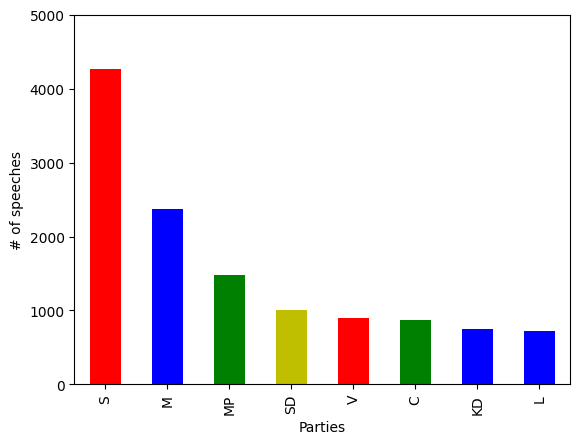

In [4]:
import matplotlib.pyplot as plt

training_data['party'].value_counts().plot(kind='bar', color=['r', 'b', 'g', 'y', 'r', 'g', 'b', 'b'])
plt.ylim(0, 5000)
plt.xlabel("Parties")
plt.ylabel("# of speeches")

Text(0, 0.5, '# of speeches')

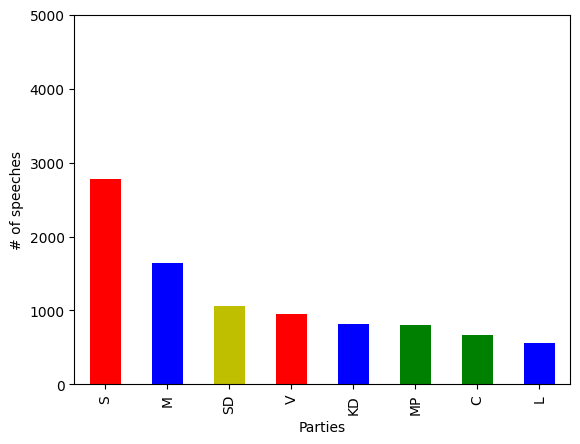

In [14]:
test_data['party'].value_counts().plot(kind='bar', color=['r', 'b', 'y', 'r', 'b', 'g', 'g', 'b'])
plt.ylim(0, 5000)
plt.xlabel("Parties")
plt.ylabel("# of speeches")

In [19]:
print(training_data['party'].value_counts())
print(test_data['party'].value_counts())

S     4261
M     2370
MP    1481
SD    1010
V      894
C      865
KD     743
L      719
Name: party, dtype: int64
S     2773
M     1644
SD    1060
V      950
KD     821
MP     809
C      671
L      560
Name: party, dtype: int64


Some of the differences we can see between the plots are that: 
* The parties S, M, and MP had significantly less speeches in 2018/2019 than in 2017/2018.
* The MP party had less speeches than the SD, V and KD parties in 2018/2019 than in 2017/2018.

If we compare the two plots to the 2018 election we can see that:
* The MP party had more speeches than seats in the riksdag, relatively to the other parties.
* The C party had less speeches than seats in the riksdag, relatively to the other parties.

If we compare the two plots to the 2014 election we can see that:
* The MP party's speeches in 2017/2018 matches more closesly the 2014 results.

## Problem 2: Naive Bayes classifier

You are now ready to train and evaluate a classifier. More specifically, we ask you to train a [Multinomial Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html#multinomial-naive-bayes) classifier. You will have to

1. vectorize the speeches in the training data
2. instantiate and fit the Naive Bayes model
3. evaluate the model on the test data

The scikit-learn library provides a convenience class [Pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) that allows you to solve the first two tasks with very compact code. For the evaluation you can use the function [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html), which will report per-class precision, recall and F1, as well as overall accuracy.

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

pipeNB = Pipeline([('vectorizer', TfidfVectorizer()), ('Naive bayes', MultinomialNB())])
pipeNB.fit(training_data['words'], training_data['party'])
pipeNB.score(test_data['words'], test_data['party'])

0.29866494401378124

Would you have expected the results that you got?

The naive bayes classifier gave us lower result than expected. If the had a classifier that would always guess the class with the most samples we would have gotten an accuracy ~0.299, which is about the same as what naive bayes got.

## Problem 3: Baselines

Evaluation metrics such as accuracy should not be understood as absolute measures of performance, but should be used only to compare different classifiers. When other classifiers are not available, a simple baseline is a classifier that generates predictions by random sampling, respecting the training set&rsquo;s class distribution. This baseline is implemented by the class [DummyClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html). What is the performance of the random baseline on the test data?

In [5]:
from sklearn.dummy import DummyClassifier

pipeDumb = Pipeline([('vectorizer', TfidfVectorizer()), ('Naive bayes', DummyClassifier(strategy='uniform'))])
pipeDumb.fit(training_data['words'], training_data['party'])
pipeDumb.score(test_data['words'], test_data['party'])

0.12198535745047373

An even dumber baseline is to predict, for every document, that class which appears most often in the training data. This baseline is also called the most frequent class baseline. What is the accuracy of that baseline on the test data?

In [6]:
pipeDumber = Pipeline([('vectorizer', TfidfVectorizer()), ('Naive bayes', DummyClassifier(strategy='most_frequent'))])
pipeDumber.fit(training_data['words'], training_data['party'])
pipeDumber.score(test_data['words'], test_data['party'])

0.298557278208441

## Problem 4: Creating a balanced data set

As you saw in Problem&nbsp;1, the distribution of the speeches over the eight different parties (classes) is imbalanced. One technique used to alleviate this is **undersampling**, in which one randomly removes samples from over-represented classes until all classes are represented with the same number of samples.

Implement undersampling to create a balanced subset of the training data. Rerun the evaluation from Problem&nbsp;2 on the balanced data and compare the results. Summarise your results in a short text.

**Hint:** Your balanced subset should consist of 5,752 speeches.

In [14]:
sample_size = training_data['party'].value_counts().min(axis=0)
res = training_data.groupby('party').apply(lambda x: x.sample(sample_size))

pipeNB_under = Pipeline([('vectorizer', TfidfVectorizer()), ('Naive bayes', MultinomialNB())])
pipeNB_under.fit(res['words'], res['party'])
pipeNB_under.score(test_data['words'], test_data['party'])

0.401916451335056

By applying undersampling we got a significantly better result and now the naive bayes performs better than most frequent quessing.

## Problem 5: Confusion matrix

A **confusion matrix** is a specific table that is useful when analysing the performance of a classifier. In this table, both the rows and the columns correspond to classes, and each cell $(i, j)$ states how many times a sample with gold-standard class $i$ was predicted as belonging to class $j$.

In scitkit-learn, the confusion matrix of a classifier is computed by the function [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html). If you would rather see a visual representation, you can also use [`plot_confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

Your task is to use the confusion matrix in order to find, for each given party $p$ in the Riksdag, that other party $p'$ which the classifier that you trained in Problem&nbsp;4 most often confuses with $p$ when it predicts the party of a speaker.

/courses/TDDE16/venv/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


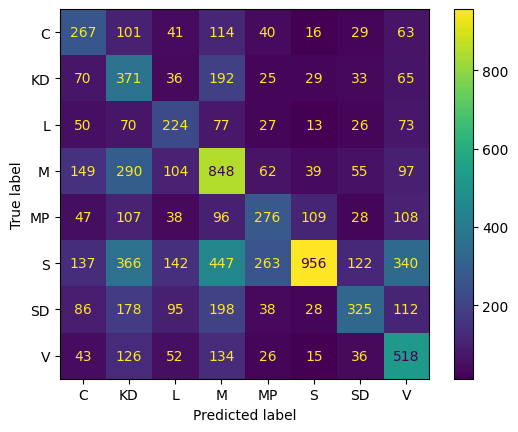

In [39]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe, test_data['words'], test_data['party'])
plt.show()

Take a minute to reflect on whether your results make sense.

## Problem 6: Grid search

Until now, you have been using the vectorizer and the Naive Bayes classifier with their default hyperparameters. When working with real-world applications, you would want to find settings for the hyperparameters that maximize the performance for the task at hand.

Manually tweaking the hyperparameters of the various components of a vectorizer‚Äìclassifier pipeline can be cumbersome. However, scikit-learn makes it possible to run an exhaustive search for the best hyperparameters over a grid of possible values. This method is known as **grid search**.

The hyperparameters of a pipeline should never be tuned on the final test set. Instead, one should either use a separate validation set, or run cross-validation over different folds. Here we will use cross-validation.

Implement a grid search with 5-fold cross-validation to find the optimal parameters in a grid defined by the following choices for the hyperparameters:

* In the vectorizer, try a set-of-words (binary) model in addition to the default bag-of-words model (two possible parameter values).
* Also in the vectorizer, try extracting bigrams in addition to unigrams (two possible parameter values).
* In the Naive Bayes classifier, try using additive smoothing with $\alpha \in \{1, 0{.}1\}$ (two possible parameter values).

Use the class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) from the scikit-learn library. Print the results of your best model, along with the parameter values that yielded these results.

In [15]:
from sklearn.model_selection import GridSearchCV

parameters = {'Naive_bayes__alpha': [0.1, 1], 
              'vectorizer__ngram_range': [(1, 1), (1, 2)],
              'vectorizer__binary': [True, False]}

pipeGrid = Pipeline([('vectorizer', TfidfVectorizer()), ('Naive_bayes', MultinomialNB())])
grid = GridSearchCV(pipeGrid, parameters)
grid.fit(res['words'], res['party'])

GridSearchCV(estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('Naive_bayes', MultinomialNB())]),
             param_grid={'Naive_bayes__alpha': [0.1, 1],
                         'vectorizer__binary': [True, False],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]})

In [16]:
print(grid.score(test_data['words'], test_data['party']))
grid.best_params_

0.46619293712316967


{'Naive_bayes__alpha': 0.1,
 'vectorizer__binary': True,
 'vectorizer__ngram_range': (1, 2)}

## Problem 7: Try to improve your results

Scikit-learn makes it easy to test different vectorizer‚Äìclassifier pipelines ‚Äì among other things, it includes different types of logistic regression classifiers, support vector machines, and decision trees. Browse the library to see which methods are supported.

Build a pipeline that you find interesting, and use grid search to find optimal settings for the hyperparameters. Print the results of your best model.

In [19]:
from sklearn.svm import SVC

parametersCustom = { 'SVM__kernel': ['rbf', 'sigmoid'],
                     'vectorizer__ngram_range': [(1, 1), (1, 2)],
                     'vectorizer__binary': [True, False]}

pipeCustom = Pipeline([('vectorizer', TfidfVectorizer()), ('SVM', SVC())])
gridCustom = GridSearchCV(pipeCustom, parametersCustom)
gridCustom.fit(res['words'], res['party'])

GridSearchCV(estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                       ('SVM', SVC())]),
             param_grid={'SVM__kernel': ['rbf', 'sigmoid'],
                         'vectorizer__binary': [True, False],
                         'vectorizer__ngram_range': [(1, 1), (1, 2)]})

In [20]:
print(gridCustom.score(test_data['words'], test_data['party']))
gridCustom.best_params_

0.4749138673557278


{'SVM__kernel': 'sigmoid',
 'vectorizer__binary': True,
 'vectorizer__ngram_range': (1, 2)}

## Reflection questions

The following reflection questions will help you prepare for the diagnostic test. Answer each of them in the form of a short text and put your answers in the cell below. You will get feedback on your answers from your lab assistant.

**RQ 2.1:** Summarise the results of your experiments for Problem&nbsp;2. Are your results ‚Äògood‚Äô or ‚Äòbad‚Äô? How do you determine that?

**RQ 2.2:** Summarise the results of your experiments for Problem&nbsp;4. Would you think that your results are typical even for other classification tasks? How would *oversampling* have looked like for this task? When would you use undersampling, when oversampling?

**RQ 2.3:** Which model performed best in your experiments for Problem&nbsp;6? Why is it important to do a hyperparameter search before drawing conclusions about the performance of a model? Why is it often not done, anyway? Why should you never tune hyperparameters on the test set?

**2.1**: The result is bad because there was no improvement on baseline (which in this case was the most frequent classifier).

**2.2**: It‚Äôs common that classes are unbalanced in nature. Oversampling would be including the same speech multiple times for underrepresented classes. We believe that undersampling should be used when one class has significantly more samples than other classes, and oversampling should be used when one class has significantly less samples than the other classes.

**2.3**: Best parameters where:
* Binary model (Set of words)
* Unigram and bigram combined
* Alpha = 0.1

Optimising hyperparameters may give more accuracy to your model. But this takes time so it's not always done to save time. By tuning on the test set we cause the model to overfit to the test set so we don't know how good the model is in the general case.


**Congratulations on finishing L2! üëç**